In [26]:
!pip3 install sgp4
!pip3 install skyfield
!pip3 install pyIGRF

In [69]:
%run math_utils.ipynb

In [70]:
from sgp4.api import Satrec, WGS72
from skyfield.api import EarthSatellite, Time, load, wgs84
import pyIGRF
import matplotlib.pyplot as plt
import numpy as np

In [143]:
class Spacecraft_Model():

    # Spacecraft general parameters
    m = 6      # [kg] weight
    h = 0.34   # [m] hieght of chassis
    w = 0.1    # [m] width of chassis
    d = 0.1    # [m] depth of chassis
    J = [[(1/12)*m*(h**2 + d**2), 0, 0], 
         [0, (1/12)*m*(w**2 + d**2), 0], 
         [0, 0, (1/12)*m*(h**2 + w**2)]]

    # Generate a satellite orbit using orbital elements
    # This orbit is for the ISS
    # TODO: change to a more realistic orbit for this CubeSat
    satrec = Satrec()
    satrec.sgp4init(
        WGS72,           # gravity model
        'i',             # 'a' = old AFSPC mode, 'i' = improved mode
        5,               # satnum: Satellite number
        18441.785,       # epoch: days since 1949 December 31 00:00 UT
        2.8098e-05,      # bstar: drag coefficient (/earth radii)
        6.969196665e-13, # ndot: ballistic coefficient (revs/day)
        0.0,             # nddot: second derivative of mean motion (revs/day^3)
        0.1859667,       # ecco: eccentricity
        5.7904160274885, # argpo: argument of perigee (radians)
        0.5980929187319, # inclo: inclination (radians)
        0.3373093125574, # mo: mean anomaly (radians)
        0.0472294454407, # no_kozai: mean motion (radians/minute)
        6.0863854713832, # nodeo: right ascension of ascending node (radians)
    )

    # Create a EarthSatellite object using the generated satellite orbit
    ts = load.timescale()
    sat = EarthSatellite.from_satrec(satrec,ts)
    t0 = sat.epoch

    r0 = sat.at(t0).position.km
    v0 = sat.at(t0).velocity.km_per_s
    
    # Find the ideal orientation of the spacecraft in the ICRF
    b_x = -normalize(r0)
    b_y = normalize(v0)
    b_z = cross(b_x, b_y)

    # Construct the nominal DCM from inertial to body from the body axes
    # Compute the equilvalent quaternion
    dcm_0_nominal = np.stack([b_x, b_y, b_z])
    q_0_nominal = dcm_to_quaternion(dcm_0_nominal)

    # Compute the nominal angular velocity required to maintain the reference attitude
    w_nominal_i = (sat.model.no_kozai / 60) * normalize(cross(r0, v0))
    w_nominal_b = np.matmul(dcm_0_nominal, w_nominal_i)
    
    def __init__(self, dt):
        self.dt = dt

        # Provide some initial offset in both the attitude and angular velocity
        # q_offset = [0, np.sin(2*np.pi / 180 / 2), 0, np.cos(2*np.pi / 180 / 2)]
        # q_0 = quaternion_multiply(q_offset, q_0_nominal)
        q_0 = self.q_0_nominal
        # w_offset = np.array([0.005, 0 ,0])
        # w_0 = w_nominal_b + w_offset
        w_0 = np.array([0, 0, 0])

        self.q_t = q_0
        self.w_t = w_0
    
    def get_position(t):
        return self.sat.at(t).position.km

    def get_velocity(self, t):
        return self.sat.at(t).velocity.km_per_s

    # Get the value of the Earth's magnetic field
    def get_magnetic_field(self, t):
        sat = self.sat

        pos = sat.at(t)
        lat, lon = wgs84.latlon_of(pos)
        alt = wgs84.height_of(pos)
        return pyIGRF.igrf_value(lat.degrees, lon.degrees, alt.km, date.J)

    def tick(self):
        return 0

    def graph_orbit(self):
        sat = self.sat
        
        #hours = np.arange(0, sat.model.no_kozai * 60, self.dt)
        #time = self.ts.utc(2000, 6, 28, hours)
        
        t0 = Spacecraft_Model.t0
        t1 = t0 + (2*np.pi/sat.model.no_kozai)/(60*24)
        time = Spacecraft_Model.ts.linspace(t0, t1, 200)

        print(type(time))
        print(time)
    
        sat_pos = sat.at(time).position.km
        sat_posecl = sat.at(time).ecliptic_position().km
    
        re = 6378.
        
        theta = np.linspace(0, 2*np.pi, 201)
        cth, sth, zth = (lambda theta=theta: [f(theta) for f in (np.cos, np.sin, np.zeros_like)])()
        lon0 = re*np.vstack((cth, zth, sth))
        lons = []
        for phi in (np.pi/180)*np.arange(0,180,15):
            cph, sph = (lambda phi=phi: [f(phi) for f in (np.cos, np.sin)])()
            lon = np.vstack((lon0[0]*cph - lon0[1]*sph,
                             lon0[1]*cph + lon0[0]*sph,
                             lon0[2]))
            lons.append(lon)
    
        lat0 = re*np.vstack((cth,sth,zth))
        lats = []
        for phi in (np.pi/180)*np.arange(-75, 90, 15):
            cph, sph = (lambda phi=phi: [f(phi) for f in (np.cos, np.sin)])()
            lat = re*np.vstack((cth*cph, sth*cph, zth+sph))
            lats.append(lat)
    
        fig = plt.figure(figsize=[10, 8])
        
        ax  = fig.add_subplot(1, 1, 1, projection='3d')
    
        x, y, z = sat_pos
        ax.plot(x, y, z)
        for x, y, z in lons:
            ax.plot(x, y, z, '-k')
        for x, y, z in lats:
            ax.plot(x, y, z, '-k')
    
        plt.show()
        

<class 'skyfield.timelib.Time'>
<Time tt=[2451723.2857428705 ... 2451723.378128523] len=200>


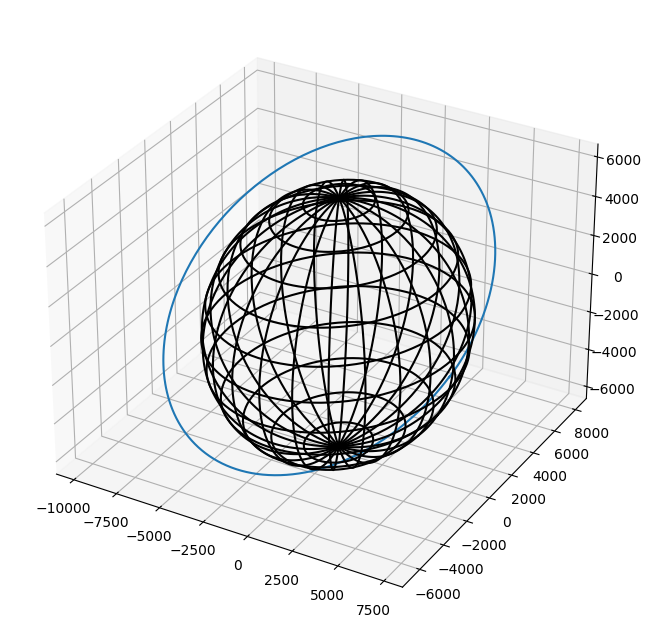

In [144]:
spacecraft = Spacecraft_Model(0.01)
spacecraft.graph_orbit()

In [88]:
date = spacecraft.ts.utc(2000, 6, 28, 0)
print(date)
pos = spacecraft.get_velocity(spacecraft.t0)
print(pos)
d, i, h, x, y, z, f = spacecraft.get_magnetic_field(date)
print("North component: {:.2f} nT".format(x))
print("East component: {:.2f} nT".format(y))
print("Vertical component: {:.2f} nT".format(z))

<Time tt=2451723.5007428704>
[-2.30057742 -4.18260775 -3.05893246]
North component: 7281.43 nT
East component: 1344.19 nT
Vertical component: 7495.82 nT
